In [84]:
import json

import pandas as pd
import matplotlib.pyplot as plt

In [11]:
path_raw_results: str = '../../benchmark_results/raw.csv'
df: pd.DataFrame = pd.read_csv(path_raw_results)

base_model_name: str = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'

## Group Data

In [12]:
columns_to_keep_raw_csv: list = ['game', 'model', 'experiment', 'episode', 'Aborted', 'Lose', 'Success']

def group_raw_csv(data: pd.DataFrame, columns_to_keep: list[str]) -> pd.DataFrame:
    df: pd.DataFrame = data.pivot_table(
        index=['game', 'model', 'experiment', 'episode'],
        columns=['metric'],
        values='value'
    ).reset_index()

    columns_to_drop: list = [column for column in list(df.keys()) if column not in columns_to_keep]
    return df.drop(columns=columns_to_drop, axis=0)

clean_csv_data: pd.DataFrame = group_raw_csv(data=df, columns_to_keep=columns_to_keep_raw_csv)

In [114]:
data_taboo = clean_csv_data[clean_csv_data.game == 'taboo']
data_imagegame = clean_csv_data[clean_csv_data.game == 'imagegame']


In [115]:
def get_term_from_episode(row):
    model_name = row['model']
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']
    
    path: str = f'../../benchmark_results/{model_name}/{game}/{experiment}/{episode}/instance.json'
    instance: dict = json.load(open(path))
    return instance['target_word']

def get_imagegame_turn_name(row):
    experiment_name = row['experiment']
    episode = row['episode']
    return f'{experiment_name[2:]}-{episode.split("_")[1]}'

def prepare_model_names(raw_names: list) -> list:
    return [m.split("--")[0].split("-t0")[0] for m in raw_names]

def prepare_value(row):
    if row['Success'] == 1.0: return 'Success'
    if row['Lose'] == 1.0: return 'Loss'
    if row['Aborted'] == 1.0: return 'Aborted'
    return 'Undefined'

def prepare_model_data(model_name, data_frame: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = data_frame[data_frame.model == model_name]
    data_base_model: dict = {}
    
    for index, row in df.iterrows():
        data_base_model.update({get_term_from_episode(row): prepare_value(row)})
        
    return data_base_model

# only consider these models for eval
models_to_consider: list = ['Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0',
                            'llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e1-_E1_D10001-t0.0',
                            'llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e1-_E1_D20001-t0.0',
                            'llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e1-_E1_D20002-t0.0',
                            'llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e1-_E1_D20003-t0.0',
                            'llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e1-_E1_D30001-t0.0',
                            'llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e1-_E1_D30002-t0.0',
                            'llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e1-_E1_D30003-t0.0',
                            'llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e1-_E1_D30004-t0.0']

plot_data: dict = {}
for model_name, short_name in zip(models_to_consider, prepare_model_names(models_to_consider)):
    prep_data = prepare_model_data(model_name, data_taboo)
    plot_data.update({short_name: prep_data})


In [116]:
plot_data

{'Unsloth-meta-llama-3.1-4bit-plain': {'responsibility': 'Loss',
  'boy': 'Success',
  'touch': 'Loss',
  'rental': 'Loss',
  'provide': 'Loss',
  'fat': 'Loss',
  'principal': 'Success',
  'filter': 'Success',
  'array': 'Success',
  'combination': 'Loss',
  'none': 'Success',
  'career': 'Success',
  'transit': 'Loss',
  'rate': 'Loss',
  'host': 'Success',
  'output': 'Loss',
  'likely': 'Loss',
  'resume': 'Success',
  'clear': 'Loss',
  'short': 'Loss',
  'assure': 'Loss',
  'haven': 'Loss',
  'fighter': 'Loss',
  'obvious': 'Loss',
  'recorder': 'Success',
  'contributor': 'Loss',
  'passage': 'Loss',
  'quarterly': 'Loss',
  'cabinet': 'Success',
  'subsidiary': 'Success',
  'orient': 'Success',
  'anymore': 'Loss',
  'limousine': 'Success',
  'induce': 'Loss',
  'stimulate': 'Loss',
  'plaza': 'Success',
  'envelope': 'Success',
  'implication': 'Loss',
  'planner': 'Loss',
  'myth': 'Success',
  'autograph': 'Success',
  'synthesis': 'Success',
  'regret': 'Success',
  'transp

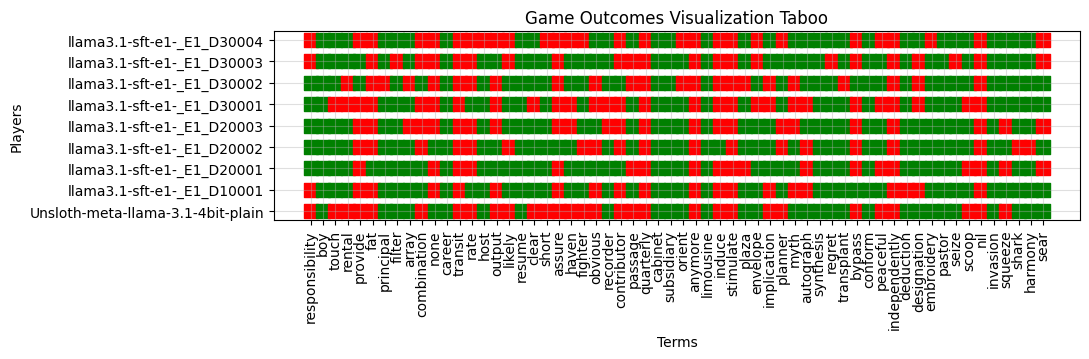

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
players = prepare_model_names(models_to_consider)
terms = list(plot_data[players[0]].keys())

# Create a dictionary to map outcomes to colors
color_map = {'Success': 'green', 'Loss': 'red', 'Aborted': 'gray', 'Undefined': 'lightblue'}

# Sample data structure (replace with your actual data)
data = plot_data

# Set up the plot
fig, ax = plt.subplots(figsize=(11, 3.7))

# Plot data points
for i, player in enumerate(players):
    for j, term in enumerate(terms):
        outcome = data[player][term]
        ax.scatter(j, i, color=color_map[outcome], s=100, marker='s')

# Customize axes
ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms)
plt.xticks(rotation=90)

ax.set_yticks(range(len(players)))
ax.set_yticklabels(players)

# Add labels and title
ax.set_xlabel('Terms')
ax.set_ylabel('Players')
ax.set_title('Game Outcomes Visualization Taboo')

# Add a grid for better readability
ax.grid(True, linestyle='-', alpha=0.4)


plt.tight_layout()
plt.savefig('../../plots/success_abort_rate_taboo.png')
plt.show()

In [56]:
players

['Unsloth-meta-llama-3.1-4bit-plain',
 'llama3.1-sft-e1-_E1_D10001',
 'llama3.1-sft-e1-_E1_D20001',
 'llama3.1-sft-e1-_E1_D20002',
 'llama3.1-sft-e1-_E1_D20003',
 'llama3.1-sft-e1-_E1_D30001',
 'llama3.1-sft-e1-_E1_D30002',
 'llama3.1-sft-e1-_E1_D30003',
 'llama3.1-sft-e1-_E1_D30004']